In [ ]:
"""
1. dataset of sentences to overall sentiment
2. create a model from dataset of word to sentiment
2.5 gramatically break down sentence instead of word by word
3. use model for our own sentence input to output overall sentiment of sentence
3.5 if a word is not known --> do sentiment analysis on its dictionary definition or neutralize
"""

In [106]:
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
import re
from sklearn.model_selection import train_test_split
import nltk.data
import spacy
import json
import random
import time

# need to run first 'python -m spacy download en_core_web_sm'
sp = spacy.load('en_core_web_sm')

lm = WordNetLemmatizer()

def normalize(d):
    mult = 1.0/sum(d.values())
    for key in d:
        d[key] *= mult

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lindseychin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lindseychin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
""" Viterbi Algorithm -- Code taken from Wikipedia """

def viterbi(obs, states, start_p, trans_p, emit_p):
    if (len(obs) == 0): return ([], 0)
    V = [{}]
    for st in states:
        prob = start_p[st] * emit_p[st][obs[0]] if obs[0] in emit_p[st] else start_p[st]
        V[0][st] = {"prob": prob, "prev": None}
        
    # Run Viterbi when t > 0
    for t in range(1, len(obs)):
        V.append({})
        for st in states:
            max_tr_prob = V[t - 1][states[0]]["prob"] * trans_p[states[0]][st]
            prev_st_selected = states[0]
            for prev_st in states[1:]:
                tr_prob = V[t - 1][prev_st]["prob"] * trans_p[prev_st][st]
                if tr_prob > max_tr_prob:
                    max_tr_prob = tr_prob
                    prev_st_selected = prev_st

            max_prob = max_tr_prob * emit_p[st][obs[t]] if obs[t] in emit_p[st] else max_tr_prob
            V[t][st] = {"prob": max_prob, "prev": prev_st_selected}

    opt = []
    max_prob = -1
    best_st = None
    # Get most probable state and its backtrack
    for st, data in V[-1].items():
        if data["prob"] > max_prob:
            max_prob = data["prob"]
            best_st = st
    opt.append(best_st)
    previous = best_st

    # Follow the backtrack till the first observation
    for t in range(len(V) - 2, -1, -1):
        opt.insert(0, V[t + 1][previous]["prev"])
        previous = V[t + 1][previous]["prev"]

    return (opt, max_prob)

In [107]:
col_names = ["sentiment", "ids", "date", "flag", "user", "text"]
df = pd.read_csv(
    'training.1600000.processed.noemoticon.csv',
    header=None, encoding="ISO-8859-1", names=col_names)

# normalize to 0 to 1 values
df['sentiment'] = df['sentiment'].replace(4, 1)

X_train, X_test, y_train, y_test = train_test_split(df, df['sentiment'], test_size = 0.005, random_state=0)

df = X_test

In [108]:
NEGATION_WORDS = ['not', 'no']
STOP_WORDS = stopwords.words('english')

for word in NEGATION_WORDS:
    STOP_WORDS.remove(word)

URL_PATTERN = r'((https://[^ ]*|(http://)[^ ]*|( www\.)[^ ]*))'
USER_PATTERN = '@[^\s]+'
PUNCTUATIONS = ['!', '?', '&quot;']

processed = []

# NOTE TO SELF: REMOVE PUNCTUATION BC SPACY
for sentiment, tweet in zip(df['sentiment'], df['text']):
    tweet = tweet.lower()
    tweet = re.sub(URL_PATTERN, '', tweet)
    tweet = re.sub(USER_PATTERN, '', tweet)
    for p in PUNCTUATIONS:
        tweet = tweet.replace(p, '')
    for sw in STOP_WORDS:
        tweet = re.sub(r'\b{0}\b'.format(sw), '', tweet)
    for w in NEGATION_WORDS:
        tweet = re.sub(r'\b{0} \b'.format(w), '{0}_'.format(w), tweet)
        
    processed.append((sentiment, tweet))    
    
df = pd.DataFrame(data=processed, columns=['sentiment', 'tweet'])

In [109]:
"""NAIVE MODEL"""
X_train, X_test, y_train, y_test = train_test_split(df, df['sentiment'], test_size = 0.05, random_state=0)

model = {}
for sentiment, tweet in zip(X_train['sentiment'], X_train['tweet']):
    for word in tweet.split():
        word = lm.lemmatize(word)
        if word in model:
            count, avg = model[word]
            model[word] = (count+1, (count*avg+sentiment) / (count+1))
        else:
            model[word] = (1, sentiment)

In [9]:
"""SUPERVISED TRANSITON + EMISSION MATRICES"""
pos_tweets = X_train[X_train["sentiment"] == 1]

VALID_POS = set(['NOUN', 'ADJ', 'VERB', 'PRON', 'PROPN'])

#name pending
def remap_pos(pos, val):
    if pos == 'NOUN' or pos == 'PRON' or pos == 'PROPN':
        return 'NOUN'
    prefix = 'POS_' if val >= 0.5 else 'NEG_'
    return prefix + pos

def supervised_model(tweets):
    transition = {
        'NOUN': { 'NOUN': 0, 'POS_VERB': 0, 'POS_ADJ': 0, 'NEG_VERB': 0, 'NEG_ADJ': 0},
        'POS_VERB': { 'NOUN': 0, 'POS_VERB': 0, 'POS_ADJ': 0, 'NEG_VERB': 0, 'NEG_ADJ': 0},
        'POS_ADJ': { 'NOUN': 0, 'POS_VERB': 0, 'POS_ADJ': 0, 'NEG_VERB': 0, 'NEG_ADJ': 0},
        'NEG_VERB': { 'NOUN': 0, 'POS_VERB': 0, 'POS_ADJ': 0, 'NEG_VERB': 0, 'NEG_ADJ': 0},
        'NEG_ADJ': { 'NOUN': 0, 'POS_VERB': 0, 'POS_ADJ': 0, 'NEG_VERB': 0, 'NEG_ADJ': 0}
    }

    emission = {
        'NOUN': {},
        'POS_VERB': {},
        'POS_ADJ': {},
        'NEG_VERB': {},
        'NEG_ADJ': {}
    }
    
    pi = {
        'NOUN': 0,     
        'POS_VERB': 0,
        'POS_ADJ': 0,
        'NEG_VERB': 0,
        'NEG_ADJ': 0
    }

    for tweet in pos_tweets['tweet']:
        sentence = sp(tweet)
        cleaned_sentence = [(lm.lemmatize(word.text), word.pos_) for word in sentence if word.pos_ in VALID_POS]
        for i in range(len(cleaned_sentence)):
            word,pos = cleaned_sentence[i]
            if word not in model: continue
            val = model[word][1]
            pos = remap_pos(pos, val)
            if i != 0:
                prev_word, prev_pos = cleaned_sentence[i-1]
                if prev_word not in model: continue
                prev_val = model[prev_word][1]
                prev_pos = remap_pos(prev_pos, prev_val)
                transition[prev_pos][pos] += 1
            else:
                pi[pos] += 1

            emission[pos][word] = emission[pos].get(word, 0) + 1

    for key in transition:
        normalize(transition[key])

    for key in emission:
        normalize(emission[key])

    normalize(pi)
        
    return (pi, transition, emission)

In [7]:
"""Baum-Welch approximation for Matrices"""

def distribute(values, num_partitions):
    if num_partitions <= len(values):
        splits = np.array_split(np.array(values), num_partitions)
        return [ i for i in range(len(splits)) for j in range(len(splits[i])) ]
    else:
        return [ random.choice(range(num_partitions)) for value in values ]

def forward(values, tr, em, initial_dist):
    alpha = { x: {} for x in range(len(values)) }

    for s in tr.keys():
        alpha[0][s] = initial_dist[s] * em[s][values[0]]
    for t in range(1, len(values)):
        for s in tr.keys():
            alpha[t][s] = sum([ alpha[t-1][s] * tr[s_p][s] * em[s][values[t]] for s_p in tr.keys() ])

    return alpha

def backward(values, tr, em):
    beta = [ {} for t in range(len(values)) ] 
    beta[-1] = { s: 1 for s in tr.keys() }
    
    for t in range(len(values) - 2, -1, -1):
        for s in tr.keys():
            beta[t][s] = sum([ beta[t+1][s_p] * tr[s][s_p] * em[s_p][values[t+1]] for s_p in tr.keys() ]) 
    return beta

def normalize_model(pi, tr, em):
    normalize(pi)
    for s in tr.keys():
        normalize(tr[s])
    
    for s in em.keys():
        normalize(em[s])
        
def initialize(tweets, num_states):
    # initialize matrices
    tr = {}
    em = {} 
    pi = {}
    states = []
    
    for i in range(num_states):
        s_i = 's_{0}'.format(i)
        states.append(s_i)
        # initialize tr as random
        tr[s_i] = {}
        for j in range(num_states):
            s_j = 's_{0}'.format(j)
            tr[s_i][s_j] = random.random()
        normalize(tr[s_i])
            
        # also initialize em num of states
        em[s_i] = {}
        
        # also initialize initial distribution
        pi[s_i] = 1.0 / num_states
        
    for tweet in tweets:
        words = [lm.lemmatize(word) for word in tweet.split()]
        
        distributed = distribute(words, num_states)
        
        for (word, i) in zip(words, distributed):
            s_i = 's_{0}'.format(i)
            if word not in em[s_i]:
                for j in range(num_states):
                    s_j = 's_{0}'.format(j)
                    em[s_j][word] = 0
            em[s_i][word] += 1
            
    for s in em:
        normalize(em[s])
        
    return (tr, em, pi)

def bw(tweets, num_states=4, num_iter=10, init=None):
    if init is None:
        tr, em, pi = initialize(tweets, num_states)
    else:
        tr, em, pi = init
    
    states = tr.keys()
    
    # iterate to improve values
    for it in range(num_iter):
        start_time = time.time()
        # improve tr and em
        R = []
        for tweet in tweets:
            words = [lm.lemmatize(word) for word in tweet.split()]
            
            if len(words) == 0: continue

            # estimation
            alpha = forward(words, tr, em, pi)
            beta = backward(words, tr, em)

            # E step
            xi = [ { s1: { s2: 0 for s2 in states} for s1 in states } for x in range(len(words)) ]
            gamma = [ { s1: 0 for s1 in states } for x in range(len(words)) ]
            for t in range(len(words)):
                gamma_denominator = sum([alpha[t][s] * beta[t][s] for s in states])
                if t == len(words) - 1:
                    for s1 in states:
                        gamma[t][s1] = alpha[t][s1] * beta[t][s1] / gamma_denominator if gamma_denominator != 0 else 0
                    continue

                xi_denominator = sum([alpha[t][s1] * tr[s1][s2] * em[s2][words[t+1]] * beta[t+1][s2]
                                      for s1 in states for s2 in states])

                for s1 in states:
                    for s2 in states:
                        if s1 not in xi[t]: xi[t][s1] = {}

                        # might want to flip alpha in forward function to match beta format
                        xi[t][s1][s2] = alpha[t][s1] * tr[s1][s2] * em[s2][words[t+1]] * beta[t+1][s2] / xi_denominator \
                        if xi_denominator != 0 else 0

                    gamma[t][s1] = alpha[t][s1] * beta[t][s1] / gamma_denominator if gamma_denominator != 0 else 0
            r_values = ( words, gamma, xi )
            R.append(r_values)

        # M step
        for s1 in states:
            pi[s1] = sum([gamma[0][s1] for _,gamma,_ in R]) / len(R)

            tr_denominator = sum([xi[t][s1][s] for s in states for (words, _, xi) in R for t in range(len(words)-1)])
            for s2 in states:
                tr_numerator = sum([xi[t][s1][s2] for (words, _, xi) in R for t in range(len(words)-1) ])
                tr[s1][s2] = tr_numerator / tr_denominator if tr_denominator != 0 else 0

            em_denominator = sum([gamma[t][s1] for (words, gamma, _) in R for t in range(len(words))])
            for w in em[s1]:
                em_numerator = sum([gamma[t][s1] for (words, gamma, _) in R for t in range(len(words)) if words[t] == w])
                if em_denominator == 0:
                    em[s1][w] = 0
                else:
                    em[s1][w] = em_numerator / em_denominator
        normalize_model(pi, tr, em)
        end_time = time.time()
        print('Iteration %d Completed, Time Taken: %s' % (it, start_time - end_time))
    return (pi, tr, em)

In [8]:
def save_model(pi, tr, em, filename='model.json'):
    with open(filename, 'w') as f:
        model = { 'pi': pi, 'tr': tr, 'em': em }
        f.write(json.dumps(model))
        f.close()

def read_model(filename='model.json'):
    with open(filename, 'r') as f:
        model = json.load(f)
        pi = model['pi']
        tr = model['tr']
        em = model['em']
        f.close()
    return (pi, tr, em)

In [119]:
""" First time run for BW -- Future runs can iterate directly on model """

pos_tweets = X_train[X_train["sentiment"] == 1]
pos_pi, pos_tr, pos_em = bw(pos_tweets['tweet'], 7)
save_model(pos_pi, pos_tr, pos_em, 'pos_model_4.json')

neg_tweets = X_train[X_train["sentiment"] == 0]
neg_pi, neg_tr, neg_em = bw(neg_tweets['tweet'], 7)
save_model(neg_pi, neg_tr, neg_em, 'neg_model_4.json')

Iteration 0 Completed, Time Taken: -234.63577938079834
Iteration 1 Completed, Time Taken: -252.38501381874084
Iteration 2 Completed, Time Taken: -360.8440594673157
Iteration 3 Completed, Time Taken: -249.30811595916748
Iteration 4 Completed, Time Taken: -233.6514880657196
Iteration 5 Completed, Time Taken: -220.96633648872375
Iteration 6 Completed, Time Taken: -206.87267684936523
Iteration 7 Completed, Time Taken: -203.448979139328
Iteration 8 Completed, Time Taken: -195.43199563026428
Iteration 9 Completed, Time Taken: -215.75608205795288
Iteration 0 Completed, Time Taken: -209.66021275520325
Iteration 1 Completed, Time Taken: -226.20388770103455
Iteration 2 Completed, Time Taken: -211.16008591651917
Iteration 3 Completed, Time Taken: -205.49960374832153
Iteration 4 Completed, Time Taken: -205.64623737335205
Iteration 5 Completed, Time Taken: -238.71908831596375
Iteration 6 Completed, Time Taken: -210.94684410095215
Iteration 7 Completed, Time Taken: -145.87218117713928
Iteration 8 Co

In [10]:
""" First time runs for Supervised -- Future runs can read directly from file """

pos_tweets = X_train[X_train["sentiment"] == 1]
pos_pi, pos_tr, pos_em = supervised_model(pos_tweets)
save_model(pos_pi, pos_tr, pos_em, 'sup_pos_model.json')

neg_tweets = X_train[X_train["sentiment"] == 0]
neg_pi, neg_tr, neg_em = supervised_model(neg_tweets)
save_model(neg_pi, neg_tr, neg_em, 'sup_neg_model.json')

In [110]:
""" Read model directly from file """
pos_model = read_model('pos_model_4.json')
neg_model = read_model('neg_model_4.json')
pos_pi, pos_tr, pos_em = pos_model
neg_pi, neg_tr, neg_em = neg_model

In [36]:
states = ('s_0', 's_1', 's_2', 's_3')
possible_observations = model.keys()
test_tweet = df['tweet'][0]
test_tweet = [ lm.lemmatize(word) for word in test_tweet.split()]
pos_result = viterbi(test_tweet, states, pos_pi, pos_tr, pos_em)
neg_result = viterbi(test_tweet, states, neg_pi, neg_tr, neg_em)

((['s_0',
   's_0',
   's_0',
   's_0',
   's_3',
   's_0',
   's_0',
   's_0',
   's_0',
   's_3',
   's_3',
   's_3',
   's_3',
   's_3'],
  2.324826052159547e-34),
 (['s_0',
   's_0',
   's_0',
   's_0',
   's_0',
   's_0',
   's_0',
   's_0',
   's_0',
   's_0',
   's_0',
   's_0',
   's_0',
   's_0'],
  0.0))

In [ ]:
"""OLD HMM MODEL"""

# transition_prob = {
#     'neg': { 'pos': 0, 'neg': 0 },
#     'pos': { 'pos': 0, 'neg': 0 }
# }
# emission_prob = {
#     'neg': { },
#     'pos': { }
# }

def state_to_num(s):
    return 1 if s == 'pos' else 0

def num_to_state(n):
    return 'pos' if n >= 0.5 else 'neg'

# for sentiment, tweet in zip(X_train['sentiment'], X_train['tweet']):
#     words = [lm.lemmatize(word) for word in tweet.split()]
    
#     for i in range(len(words)): 
#         wovrd = words[i]
        
#         # transition stuff
#         #if i != 0:
#         #    val = model[word][1]
#         #    current_state = num_to_state(val)
#         #    previous_state = num_to_state(model[words[i-1]][1])
#         #    
#         #    transition_prob[previous_state][current_state] += 1
        
#         actual_state = num_to_state(sentiment)    
#         word_state = num_to_state(model[word][1])
        
#         # transition stuff
#         transition_prob[word_state][actual_state] += 1        
    
#         # emission stuff
#         if word not in emission_prob[actual_state]:
#             emission_prob['pos'][word] = 0
#             emission_prob['neg'][word] = 0
#         emission_prob[actual_state][word] += 1    
        
# normalize -- subtract mean and divide by std
# min-max scaling
# add-one smoothing for naive bayes
            
# # normalize values in transition
# normalize(transition_prob['pos'])
# normalize(transition_prob['neg'])
# # normalize value in emission
# normalize(emission_prob['pos'])
# normalize(emission_prob['neg'])

# (transition_prob, emission_prob)

In [126]:
def estimator(tweet):
    words = [lm.lemmatize(word) for word in tweet.split()]
    vals = [model[word][1] for word in words if word in model]
    
    if len(vals) == 0:
        return 0.5
    
    return sum(vals)/len(vals)

# def hmm_estimator(tweet):
#     words = [lm.lemmatize(word) for word in tweet.split()]
    
#     tr = transition_prob
#     em = emission_prob
       
#     gl = { 'pos': 0.5, 'neg': 0.5 }

#     for i in range(len(words)):
#         word = words[i]
#         if word not in model:
#             continue
            
#         word_state = num_to_state(model[word][1])
        
#         pr = {
#             'pos': tr['pos']['pos'] * gl['pos'] + tr['neg']['pos'] * gl['neg'],
#             'neg': tr['pos']['neg'] * gl['pos'] + tr['neg']['neg'] * gl['neg']
#         }
        
#         gl['pos'] = em['pos'][word] * pr['pos']
#         gl['neg'] = em['neg'][word] * pr['neg']
        
#         # just doing this results in 69% accuracy.. but not sure if this is right.
#         #gl['pos'] = tr[word_state]['pos'] * gl['pos']
#         #gl['neg'] = tr[word_state]['neg'] * gl['neg']
        
#         normalize(gl)
    
#     return gl['pos']

def part_of_speech_obs(tweet):
    sent = sp(tweet)
    return [word.pos_ for word in sent if word.pos_ in VALID_POS]

def word_obs(tweet):
    return [lm.lemmatize(word) for word in tweet.split()]

def viterbi_estimator(tweet, pos_model=pos_model, neg_model=neg_model, obs='word_obs'):
    pos_pi, pos_tr, pos_em = pos_model
    neg_pi, neg_tr, neg_em = neg_model
    states = list(pos_tr.keys())
    possible_observations = list(model.keys()) if obs == 'word_obs' else list(VALID_POS)
    words = globals()[obs](tweet)
    pos_result = viterbi(words, states, pos_pi, pos_tr, pos_em)
    neg_result = viterbi(words, states, neg_pi, neg_tr, neg_em)
    
    res = { 'pos': pos_result[1], 'neg': neg_result[1] }
    if (res['pos'] == 0 and res['neg'] == 0):
        return 0.5
    normalize(res)
    return res['neg']

In [50]:
def compute_errors(sentiment_pairs):
    errors = [abs(est - sent) for (sent, est) in sentiment_pairs]
    avg_error = sum(errors)/len(errors)
    var_values = [(error - avg_error)**2 for error in errors]
    variance = sum(var_values)/len(var_values)

    return (avg_error, variance)
    
def rounded_pairs(sentiment_pairs):
    return [(sent, 0 if est < 0.5 else 1) for (sent, est) in sentiment_pairs]

def compute_accuracy(rounded_sentiment_pairs):
    return len([1 for (sent, est) in rounded_sentiment_pairs if sent == est]) / len(rounded_sentiment_pairs)

def print_results(pairs):
    avg_error, variance = compute_errors(pairs)
    accuracy = compute_accuracy(rounded_pairs(pairs))

    print('Accuracy:', accuracy)
    print('Average Error:', avg_error)
    print('Variance:', variance)

In [113]:
sentiment_pairs = []
for sentiment, tweet in zip(X_test['sentiment'], X_test['tweet']):
    estimated_sentiment = estimator(tweet)
    sentiment_pairs.append((sentiment, estimated_sentiment))
    
unsupervised_sentiment_pairs = []
for sentiment, tweet in zip(X_test['sentiment'], X_test['tweet']):
    estimated_sentiment = viterbi_estimator(tweet)
    unsupervised_sentiment_pairs.append((sentiment, estimated_sentiment))

print('Bayes Estimator')
print_results(sentiment_pairs)

print('-----------')

print('HMM Estimator')
print_results(unsupervised_sentiment_pairs)

Bayes Estimator
Accuracy: 0.67
Average Error: 0.45115323440686034
Variance: 0.015390271286788708
-----------
HMM Estimator
Accuracy: 0.6
Average Error: 0.4485728129602328
Variance: 0.10503111690542585


In [84]:
import nltk.data

def read_file(filename='test.txt'):
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    fp = open(filename)
    data = fp.read()
    paragraphs = data.split('\n\n')
    return [ '\n-----\n'.join(tokenizer.tokenize(paragraph)).split('\n-----\n') for paragraph in paragraphs ]

def estimate_values(paragraph_sentences, estimator='estimator'):
    paragraph_values = [ [ globals()[estimator](sentence) for sentence in paragraph ] for paragraph in paragraph_sentences ]
    values = [ sum(paragraph)/len(paragraph) for paragraph in paragraph_values ]
    return values

In [127]:
trump_speech_1 = read_file(filename='trump_inauguration.txt')
obama_speech_1 = read_file(filename='obama_inauguration.txt')
trump_speech_2 = read_file(filename='trump_riot.txt')
obama_speech_2 = read_file(filename='obama_sandy.txt')

trump_1_naive_values = estimate_values(trump_speech_1)
trump_1_hmm_values = estimate_values(trump_speech_1, estimator='viterbi_estimator')

obama_1_naive_values = estimate_values(obama_speech_1)
obama_1_hmm_values = estimate_values(obama_speech_1, estimator='viterbi_estimator')

trump_2_naive_values = estimate_values(trump_speech_2)
trump_2_hmm_values = estimate_values(trump_speech_2, estimator='viterbi_estimator')

obama_2_naive_values = estimate_values(obama_speech_2)
obama_2_hmm_values = estimate_values(obama_speech_2, estimator='viterbi_estimator')

In [136]:
from scipy.ndimage.interpolation import zoom
import numpy as np

def resize(x, length):
    ratio = length / len(x)
    return zoom(x, ratio, order=1)

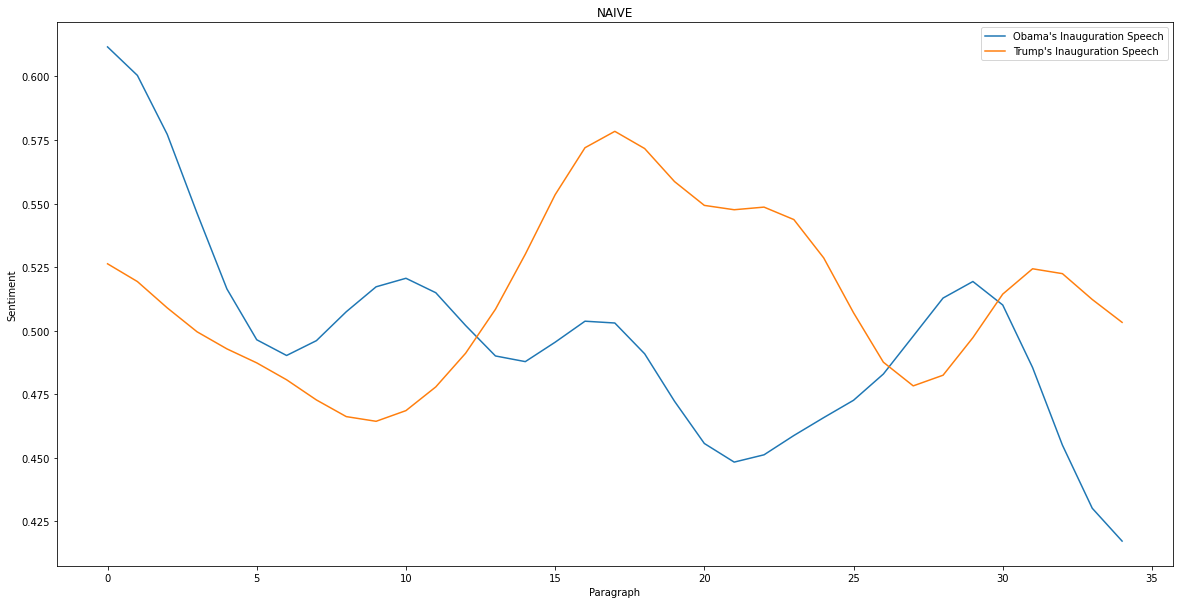

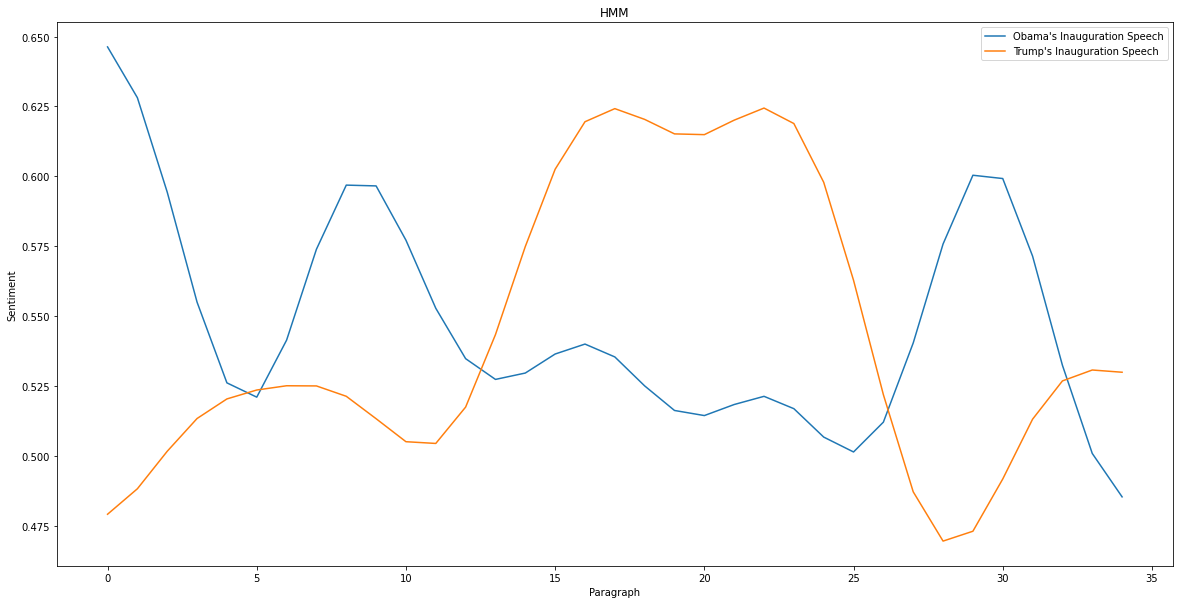

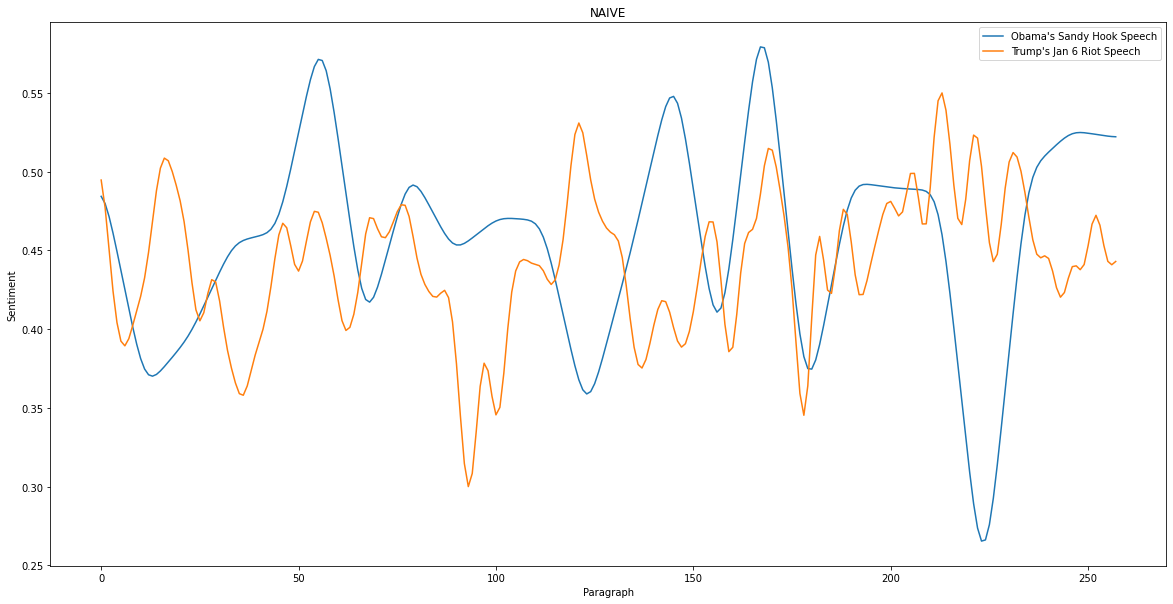

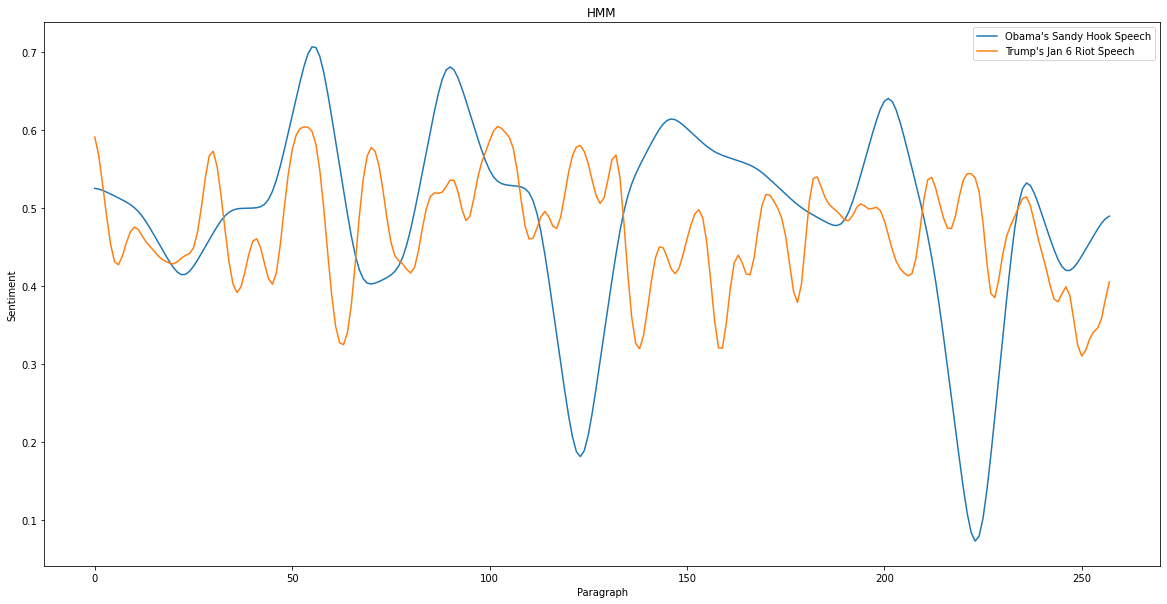

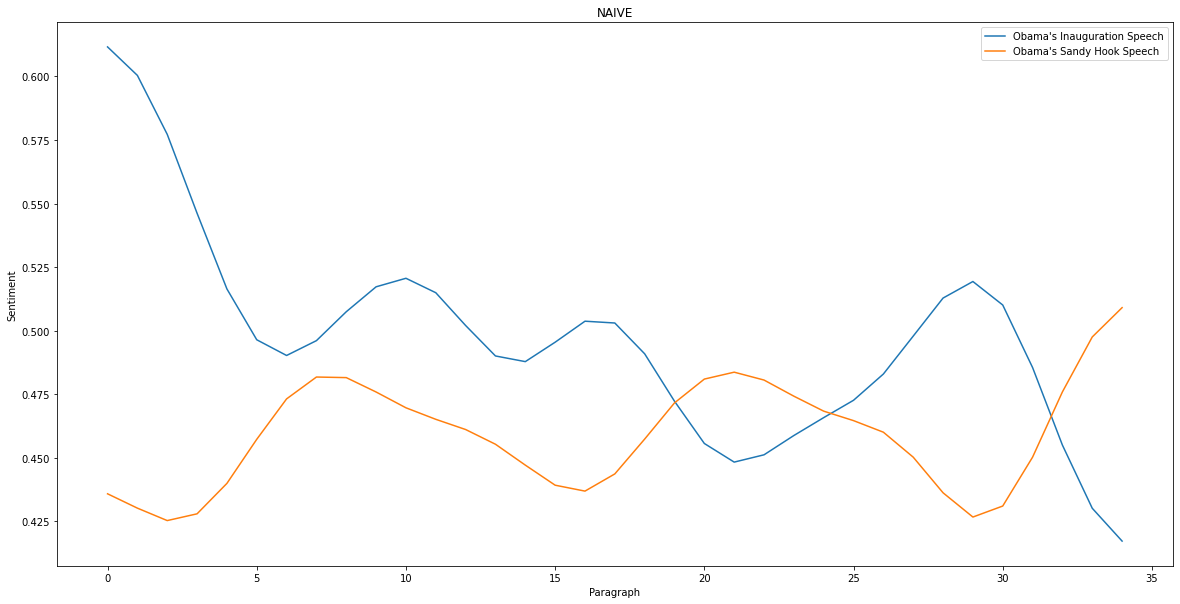

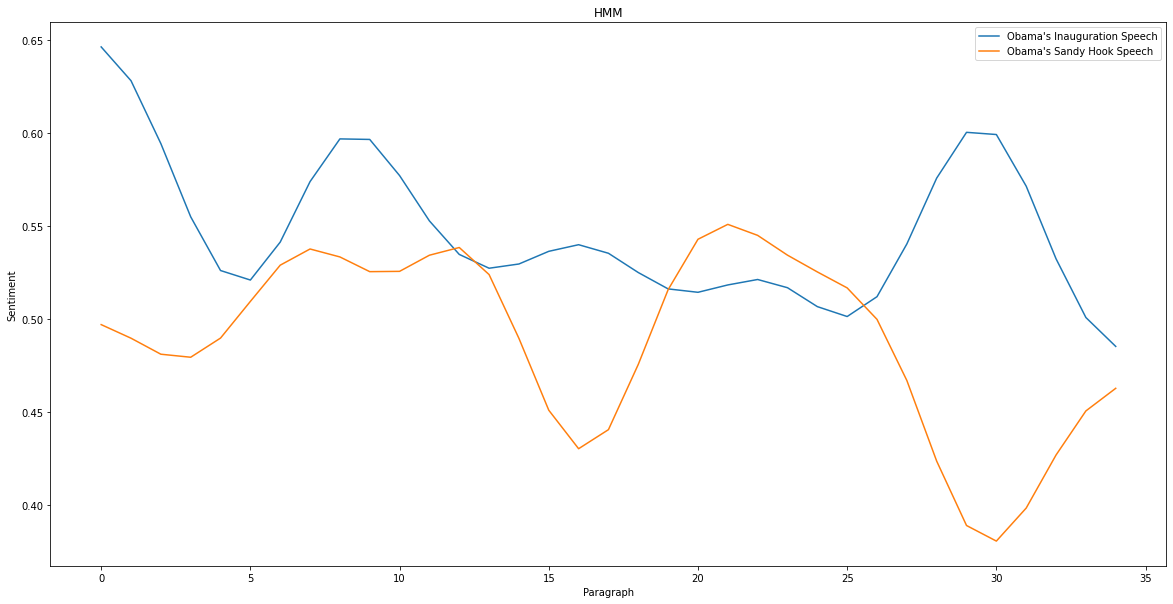

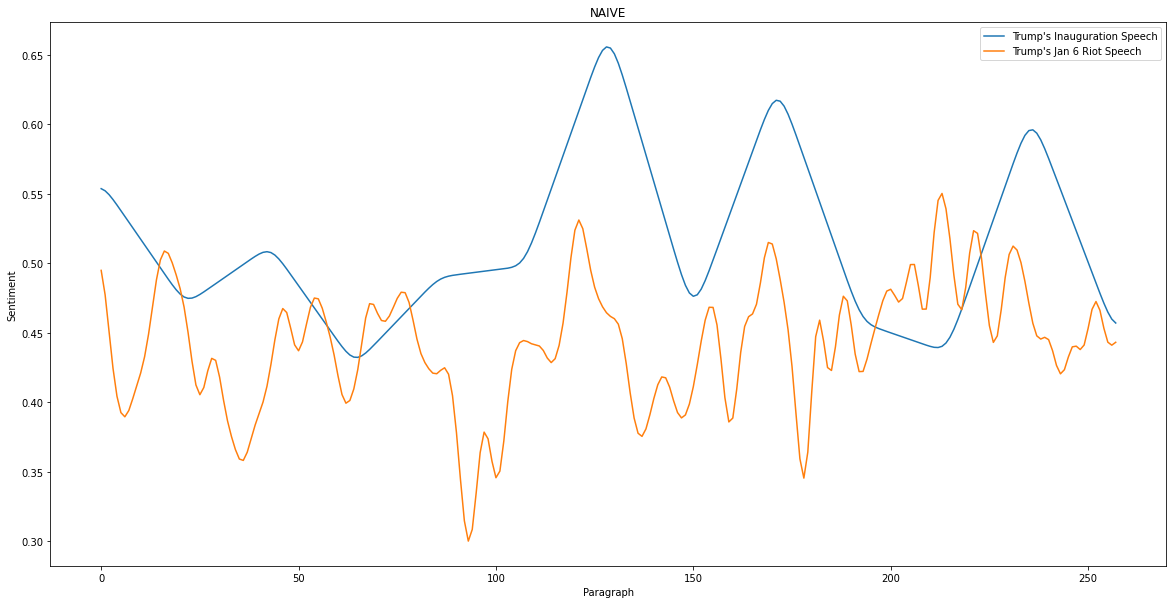

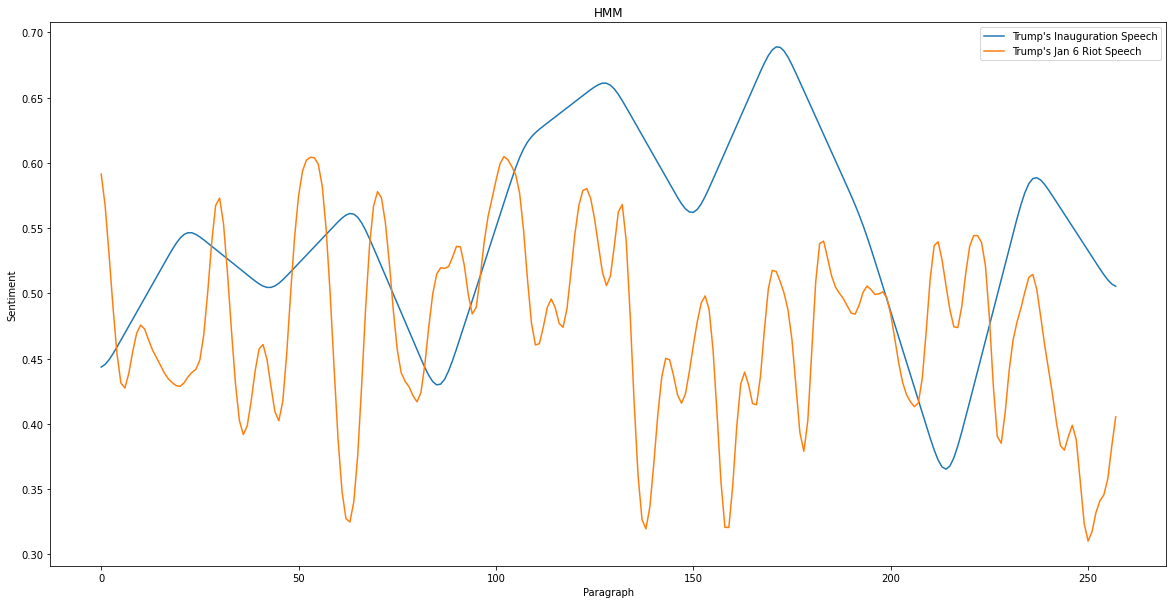

In [139]:
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d

l = len(trump_naive_values)

# plt.figure(figsize=(20,10))
# plt.plot(range(l), resize(obama_naive_values, l))
# plt.plot(range(l), gaussian_filter1d(trump_naive_values, sigma=2))
# plt.show()

# plt.figure(figsize=(20,10))
# plt.plot(range(l), resize(obama_hmm_values, l))
# plt.plot(range(l), gaussian_filter1d(trump_hmm_values, sigma=2))
# plt.show()

def graph(v1, v2, label1, label2, title):
    l1 = len(v1)
    l2 = len(v2)
            
    l = max(l1, l2)
        
    plt.figure(figsize=(20,10))
    plt.plot(range(l), gaussian_filter1d(resize(v1, l), sigma=2), label=label1)
    plt.plot(range(l), gaussian_filter1d(resize(v2, l), sigma=2), label=label2)
    plt.xlabel('Paragraph')
    plt.ylabel('Sentiment')
    plt.title(title)
    plt.legend()
    plt.show()

graph(obama_1_naive_values, trump_1_naive_values, 'Obama\'s Inauguration Speech', 'Trump\'s Inauguration Speech', 'NAIVE')
graph(obama_1_hmm_values, trump_1_hmm_values, 'Obama\'s Inauguration Speech', 'Trump\'s Inauguration Speech', 'HMM')

graph(obama_2_naive_values, trump_2_naive_values, 'Obama\'s Sandy Hook Speech', 'Trump\'s Jan 6 Riot Speech','NAIVE')
graph(obama_2_hmm_values, trump_2_hmm_values, 'Obama\'s Sandy Hook Speech', 'Trump\'s Jan 6 Riot Speech', 'HMM')

graph(obama_1_naive_values, obama_2_naive_values, 'Obama\'s Inauguration Speech', 'Obama\'s Sandy Hook Speech', 'NAIVE')
graph(obama_1_hmm_values, obama_2_hmm_values, 'Obama\'s Inauguration Speech', 'Obama\'s Sandy Hook Speech', 'HMM')

graph(trump_1_naive_values, trump_2_naive_values, 'Trump\'s Inauguration Speech', 'Trump\'s Jan 6 Riot Speech', 'NAIVE')
graph(trump_1_hmm_values, trump_2_hmm_values, 'Trump\'s Inauguration Speech', 'Trump\'s Jan 6 Riot Speech', 'HMM')